**In this script, the calculated clusters will be qualitatively interpreted to gain an understanding of each of the types of actors**

# Imports and Data Loading

In [15]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import networkx as nx

In [16]:
full_data = pd.read_csv('../results/author_full_features_and_clusters.csv')

In [17]:
# rename clusters
full_data['cluster'] = full_data['cluster'].replace({0: 'Cluster 1', 3: 'Cluster 2', 4: 'Cluster 3', 5: 'Cluster 4'})
full_data.drop(columns=['cluster_1_prob', 'cluster_2_prob'], inplace=True)
full_data.rename(columns={'cluster_0_prob': 'Cluster 1', 'cluster_3_prob': 'Cluster 2', 'cluster_4_prob': 'Cluster 3', 'cluster_5_prob': 'Cluster 4'}, inplace=True)

In [18]:
features = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

# Visualizing Node Embedidngs

In [19]:
# load embeddings from npy files
embeddings = np.load('../results/author_full_embeddings.npy')

In [20]:
# fit tsne
tsne = TSNE(n_components=2, random_state=42)

tsne_4 = tsne.fit_transform(embeddings)

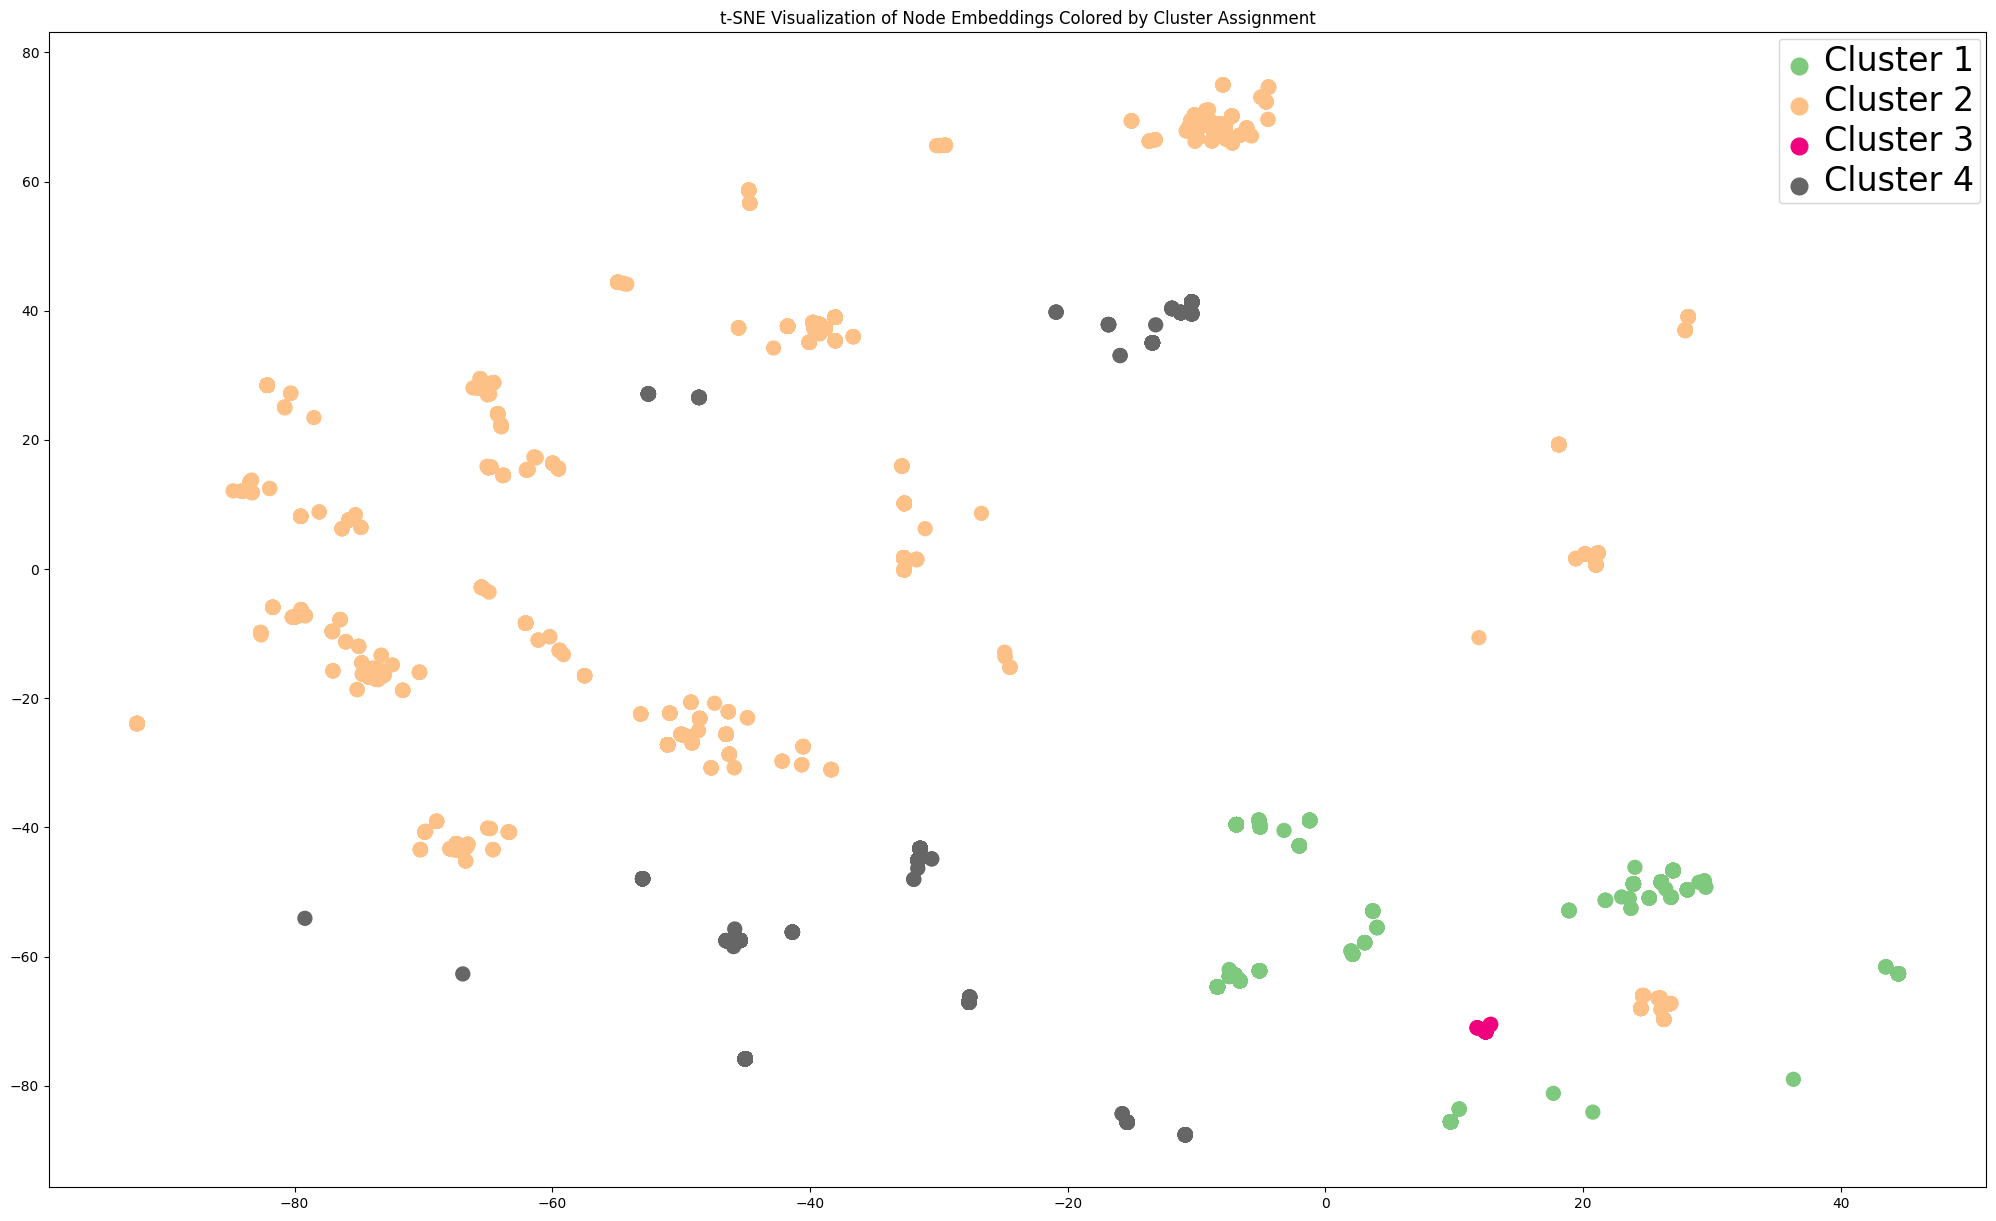

In [21]:
# plot t-SNE embeddings
plt.figure(figsize=(25, 15))
scatter = plt.scatter(tsne_4[:,0], tsne_4[:,1], c=full_data['cluster'].astype('category').cat.codes, cmap='Accent', s=100)
plt.title('t-SNE Visualization of Node Embeddings Colored by Cluster Assignment')

# legend
handles, labels = scatter.legend_elements(prop="colors")
unique_labels = full_data['cluster'].unique()
legend_labels = [f'{label}' for label in unique_labels]
legend_labels.sort()
plt.legend(handles, legend_labels, markerscale=2)

# adjust font size
plt.rc('legend', fontsize=24)
plt.rc('axes', titlesize=26)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)

# legend title
plt.gca().get_legend().set_title('')

# make points in legend bigger
plt.setp(plt.gca().get_legend().get_texts(), fontsize='24')

plt.show()

    - Well separated classes
    - pink class biggest and more dispersed
    - yellow class small and compact; probably some similarities to dark blue class

# Distribution of Linguistic Features in Clusters

In [22]:
# get mean of eaxh feature oe each cluster
features.groupby('cluster').mean()

,noun_count,verb_count,adj_count,positive_sentiment,negative_sentiment,neutral_sentiment,channel_messages,group_messages,sent_count,word_count,avg_sent_length,avg_word_length,exclamation_count,question_count,emoji_count,flesch_reading_ease,liwc_I,liwc_We,liwc_You,liwc_Other,liwc_Affect,own_message,forwarded_message,total_message_count,was_forwarded,own_message_count,forwarded_message_count,action_quotient,sentiment_quotient,toxicity
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cluster 1,47.826058,32.497649,9.507052,0.224123,0.365931,0.338289,0.000000,1.000000,2.430994,18.289211,5.560361,4.460404,0.215306,0.193946,0.447635,71.892904,0.022210,0.005637,0.010887,0.022716,0.060486,0.790640,0.117353,19.590074,0.014706,13.878676,3.790441,3.617356,0.443266,0.124415
Cluster 2,50.904810,32.210513,10.201499,0.198148,0.368583,0.362421,0.000505,0.999495,2.436130,17.656669,5.488466,4.515913,0.216822,0.199870,0.422473,71.357384,0.021802,0.005284,0.010325,0.022404,0.059968,0.779825,0.120012,22.077045,0.074021,14.294571,4.465598,3.622989,0.420388,0.122859
Cluster 3,48.250000,33.843750,8.468750,0.174001,0.423296,0.337444,0.000000,1.000000,2.125973,13.988962,4.890329,4.860964,0.323303,0.159464,0.381659,67.549332,0.014363,0.008163,0.006253,0.015034,0.089798,0.787853,0.131288,39.294118,0.000000,18.676471,14.794118,3.284581,0.435828,0.144867
Cluster 4,59.623589,37.984763,12.810384,0.193439,0.378250,0.359757,0.000564,0.999436,2.435228,17.709397,5.823512,4.506913,0.192281,0.220915,0.366053,71.795662,0.020388,0.006040,0.011669,0.023494,0.059974,0.769676,0.119855,23.445058,0.073758,14.173106,4.821375,3.721857,0.435626,0.123719


    - soome features show (small differences), others don't
    - needs to be tested if it is statistically significant

In [23]:
Counter(full_data['cluster'])

Counter({'Cluster 2': 13226,
         'Cluster 4': 1993,
         'Cluster 1': 1632,
         'Cluster 3': 34})

# Correlation

## Testing Assumptions

## Cluster 1

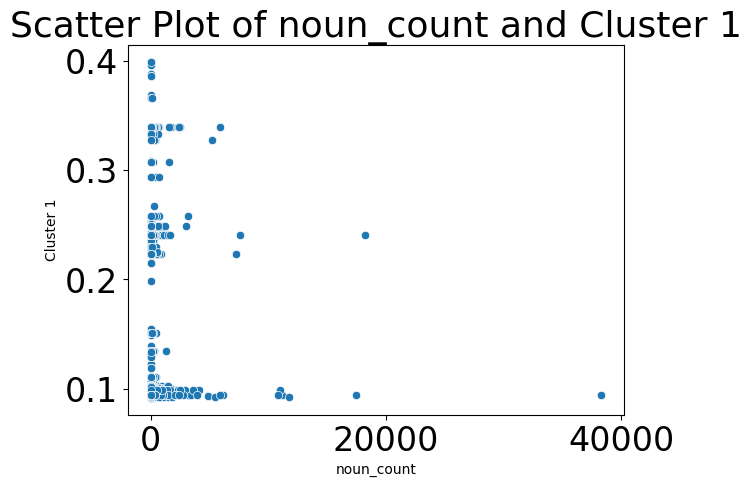

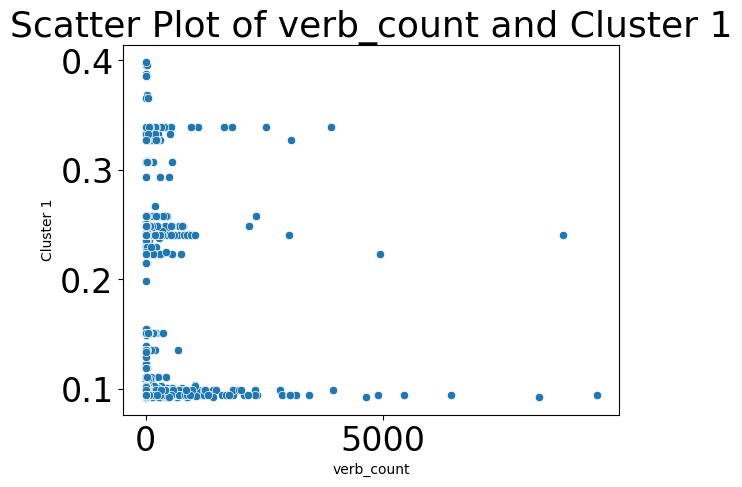

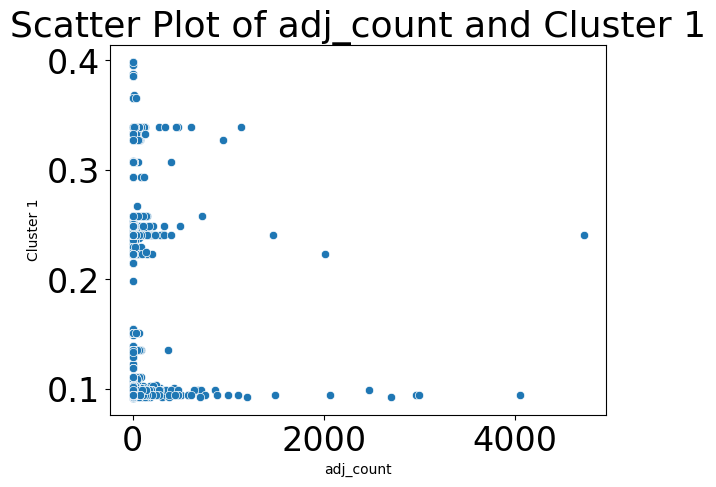

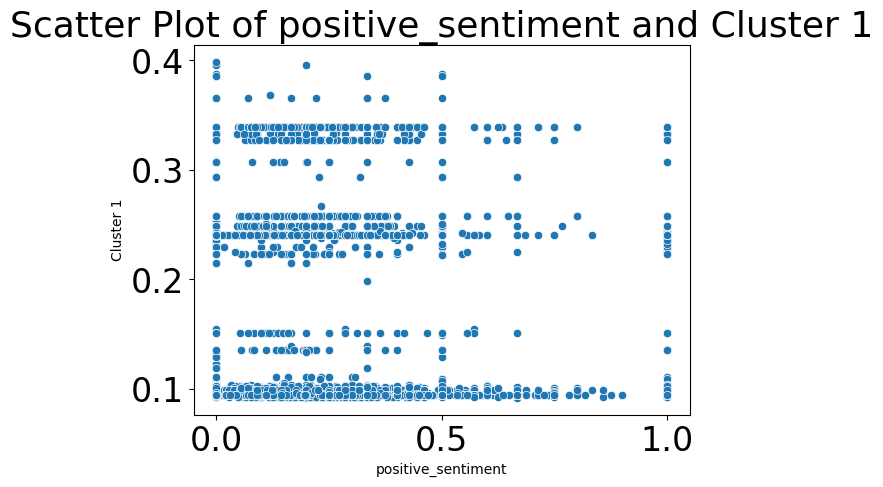

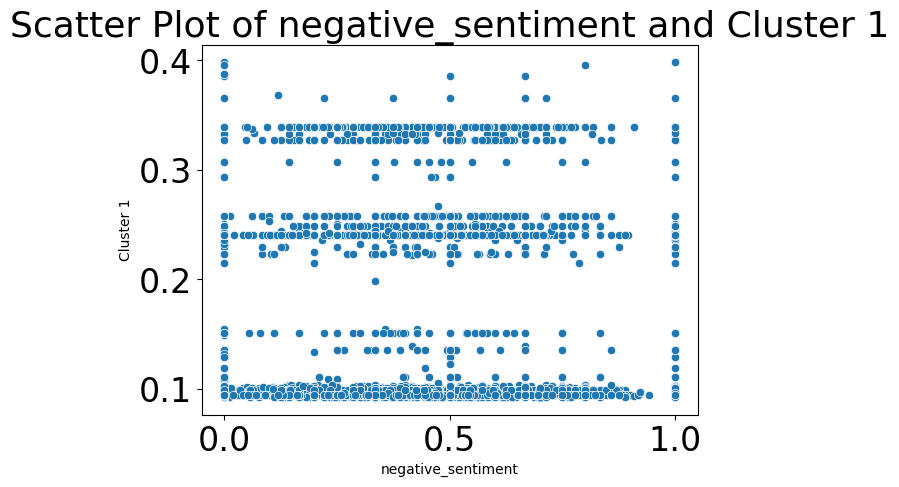

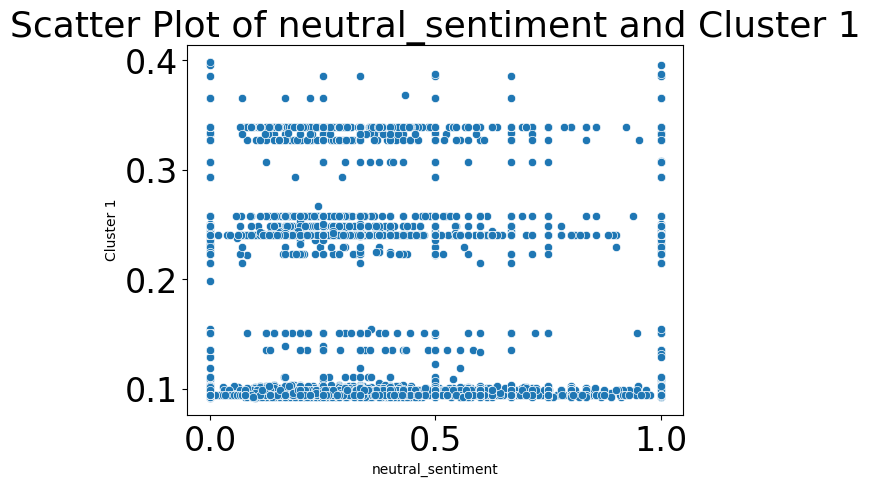

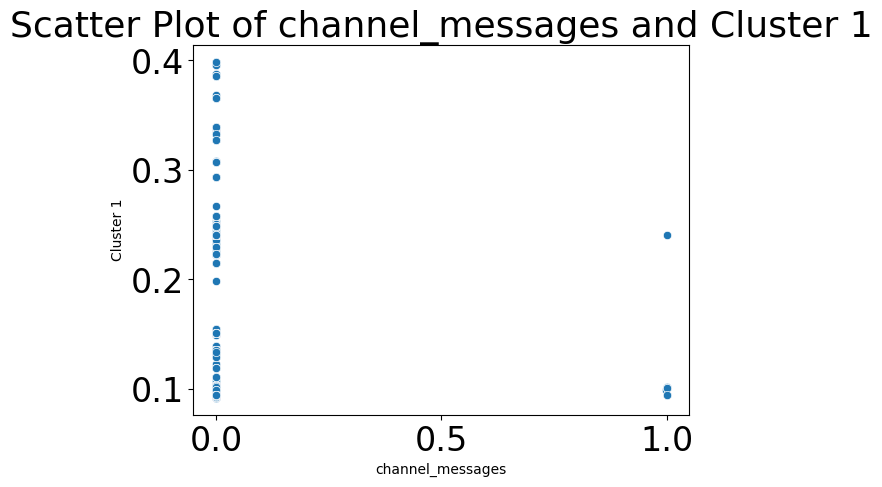

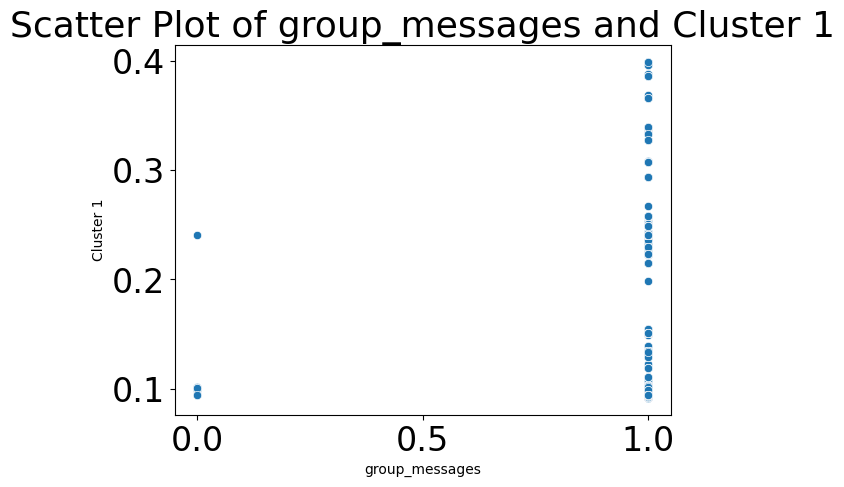

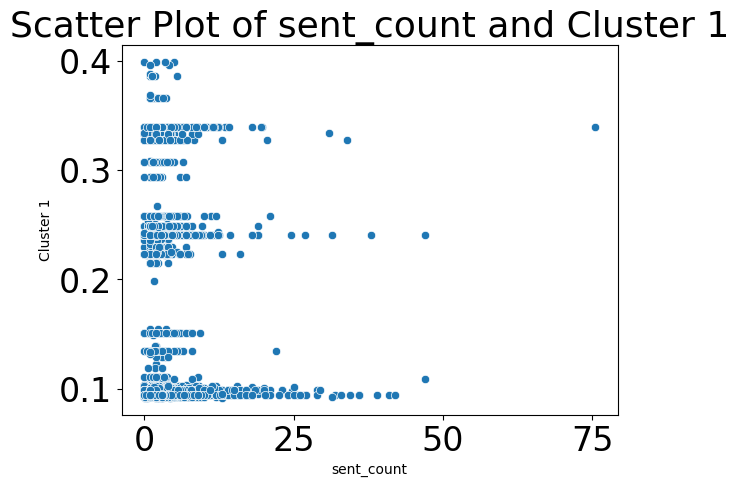

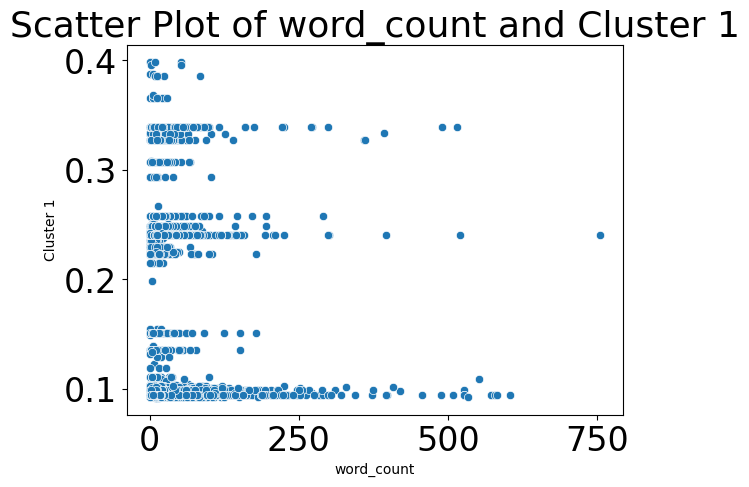

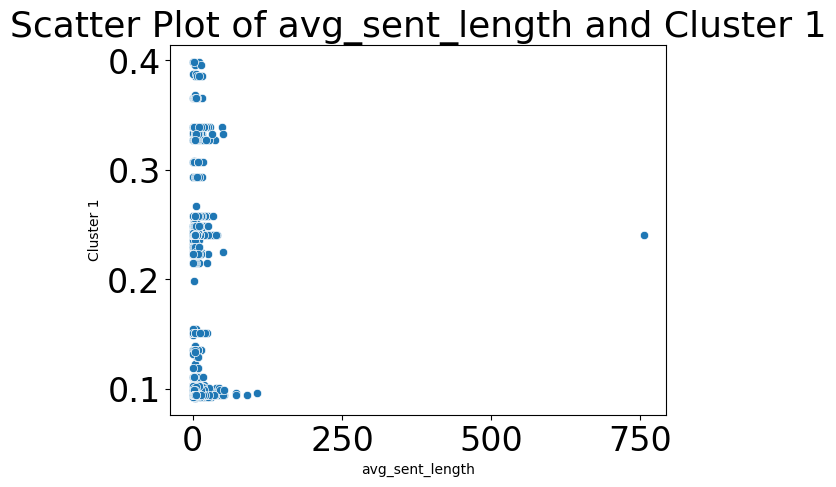

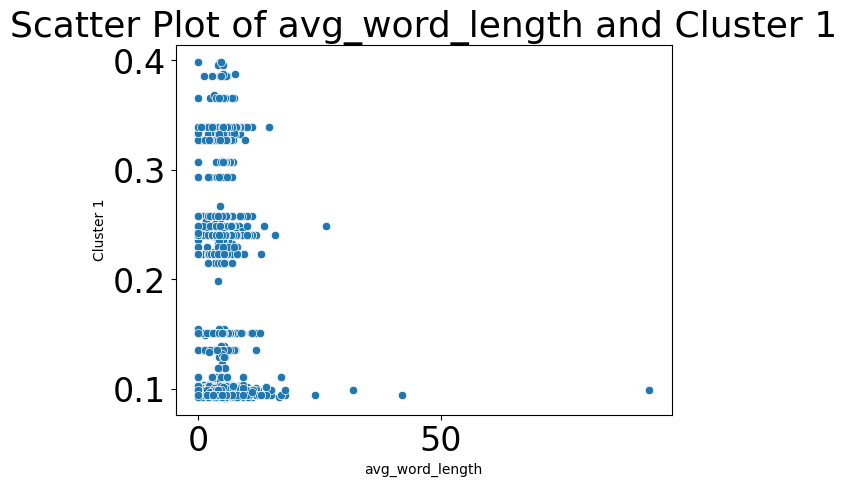

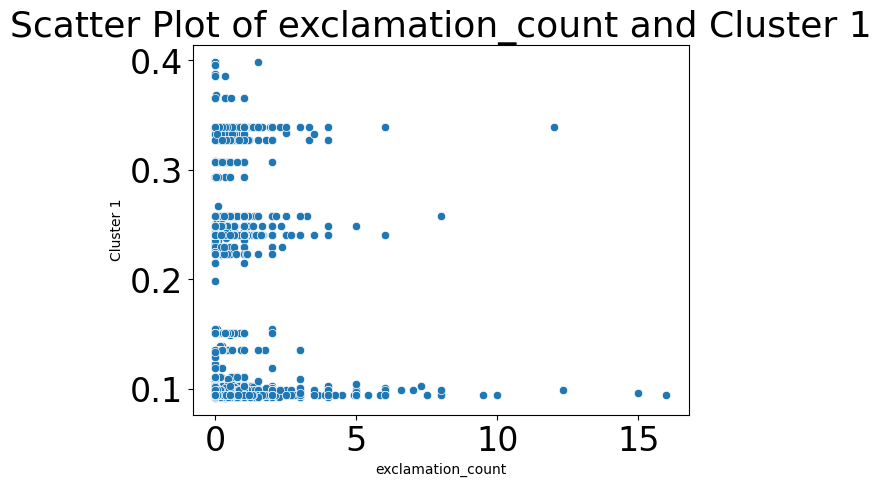

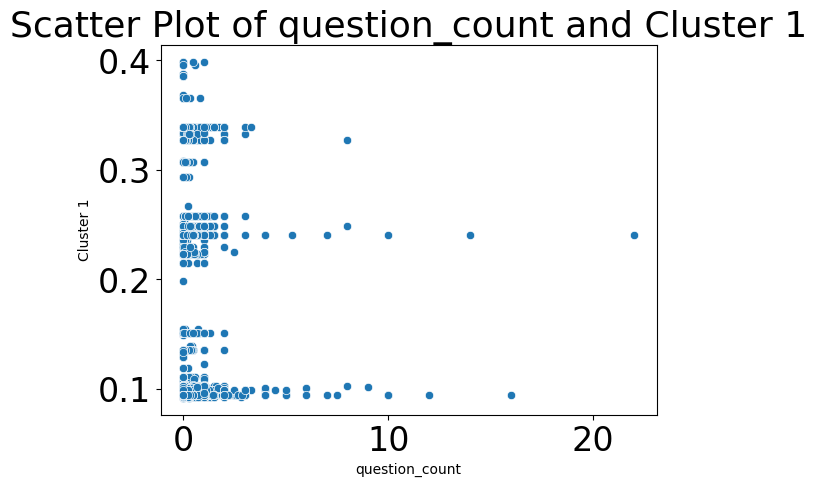

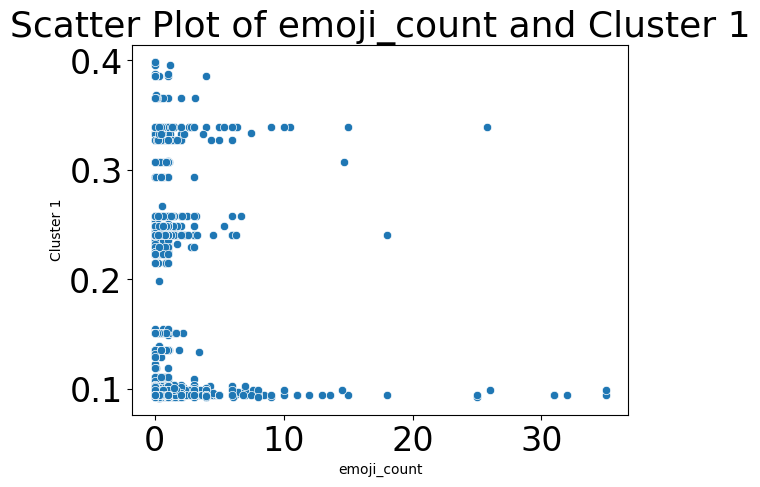

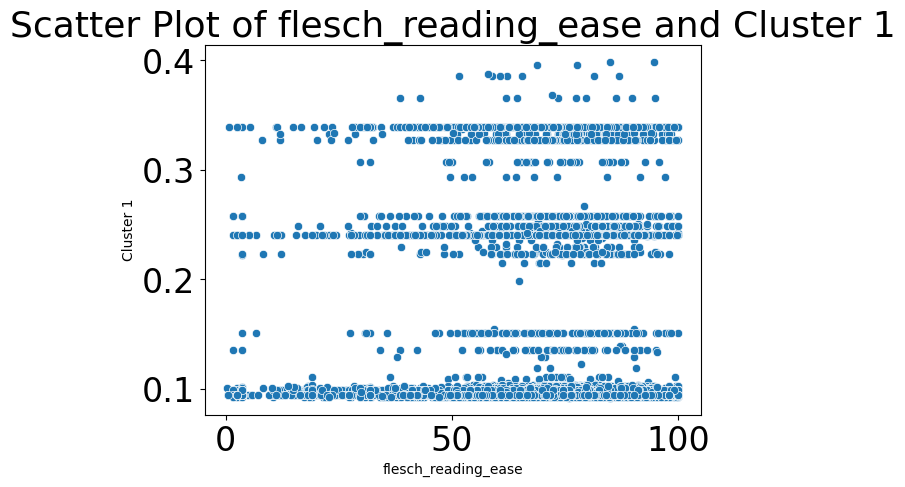

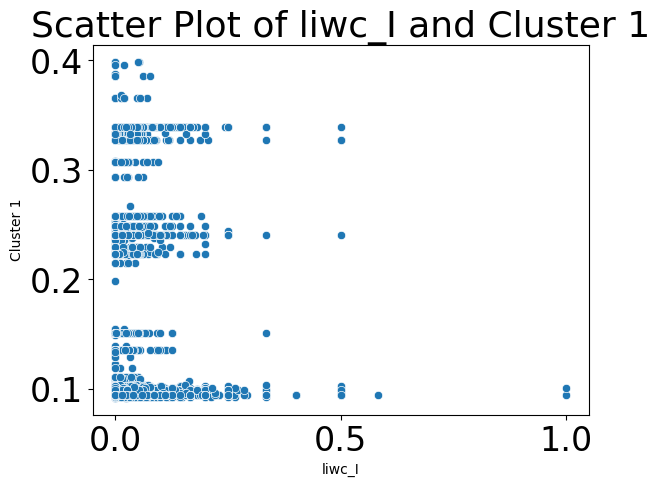

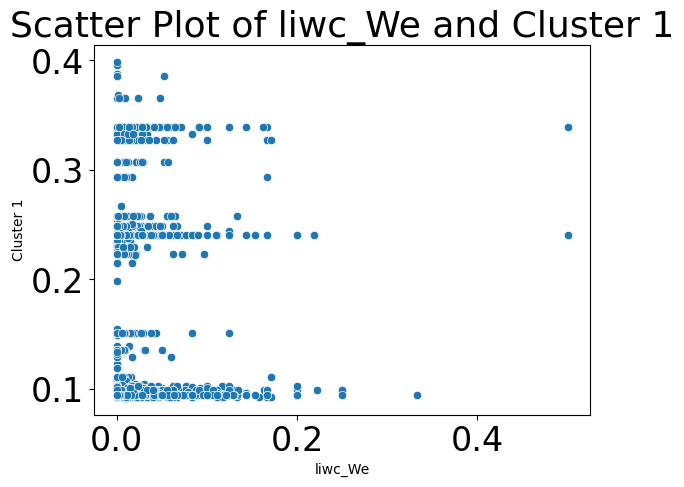

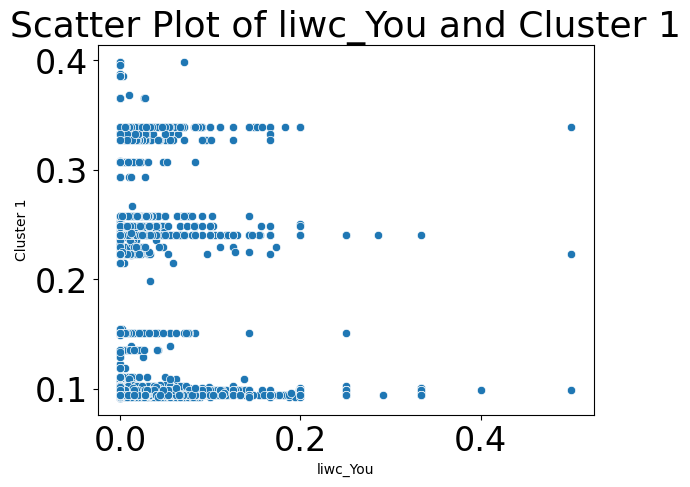

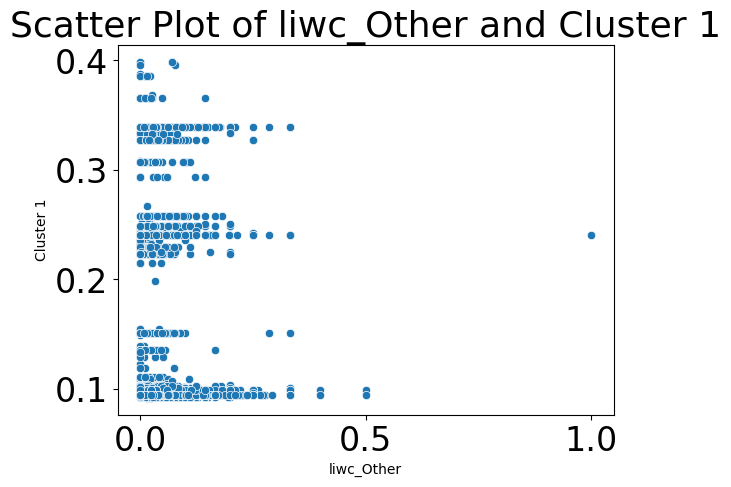

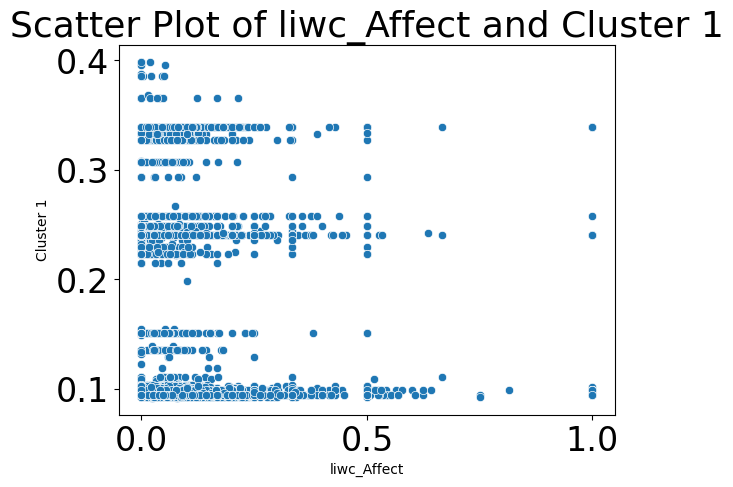

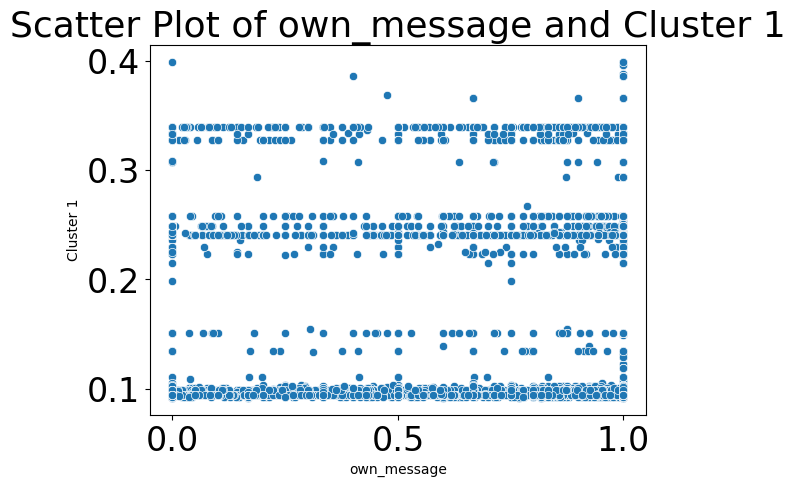

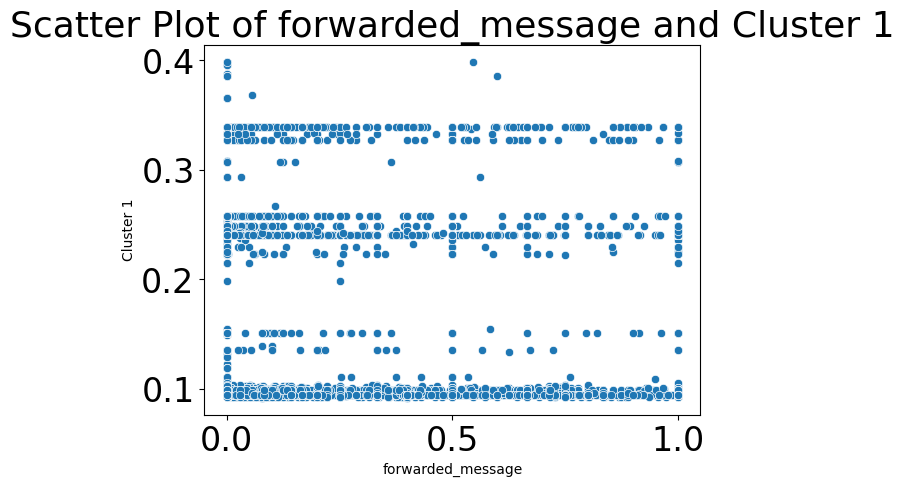

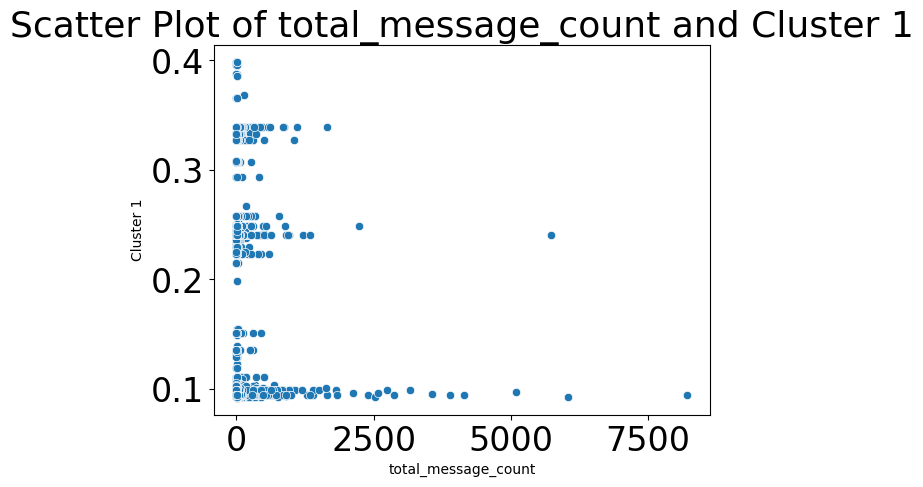

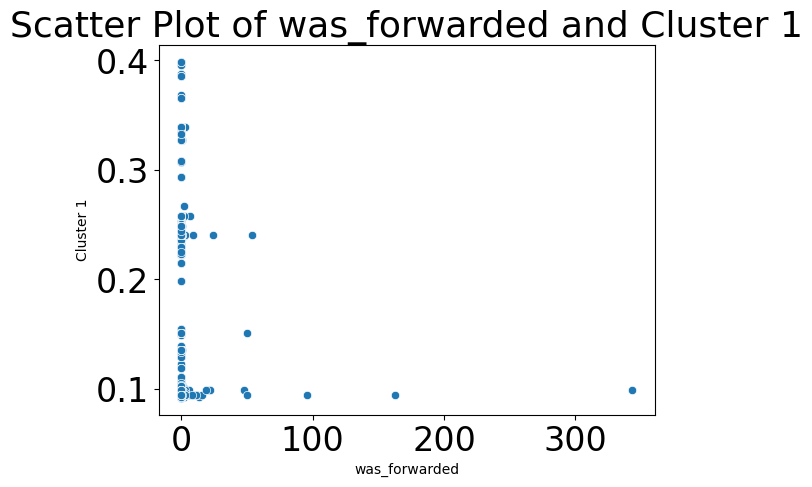

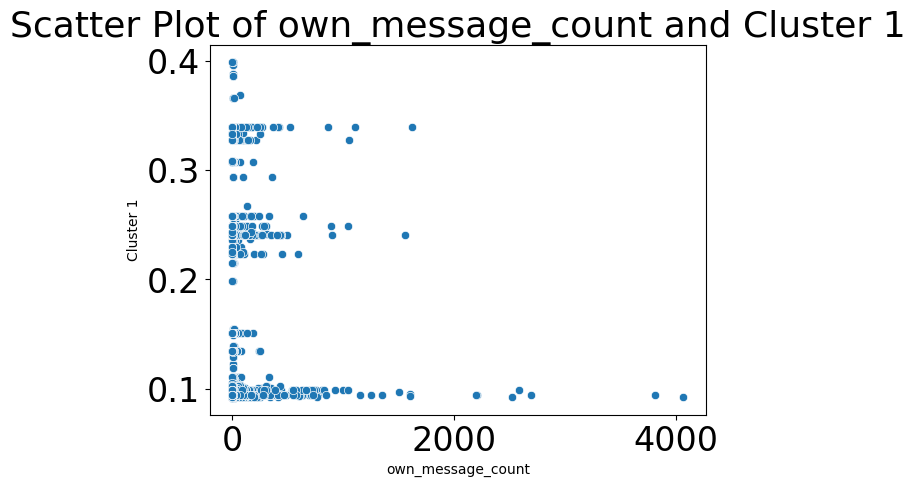

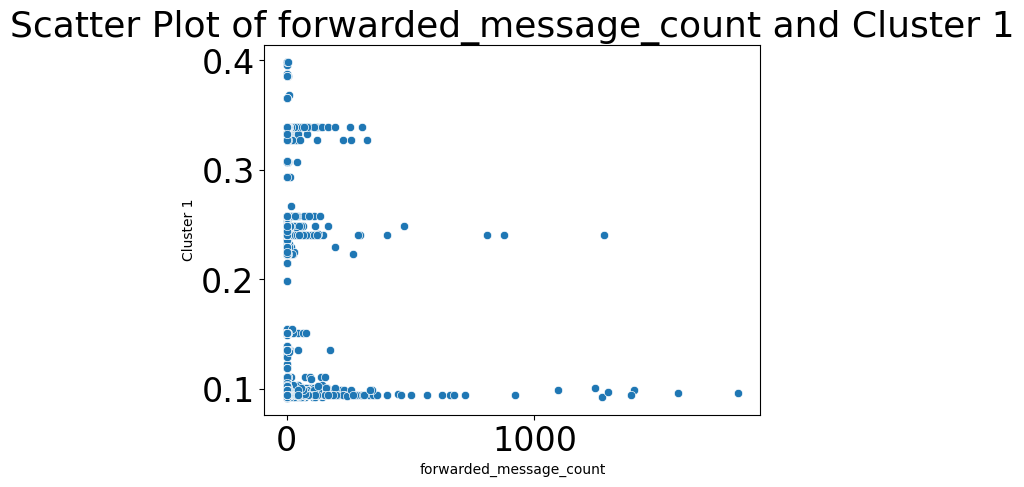

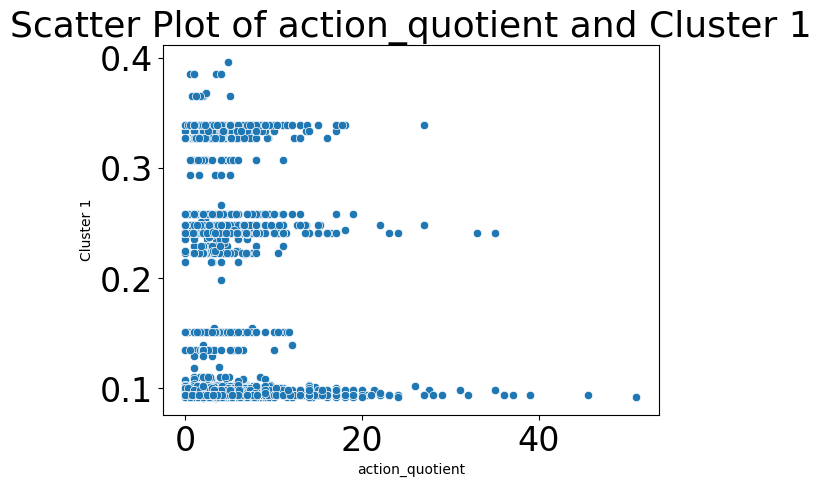

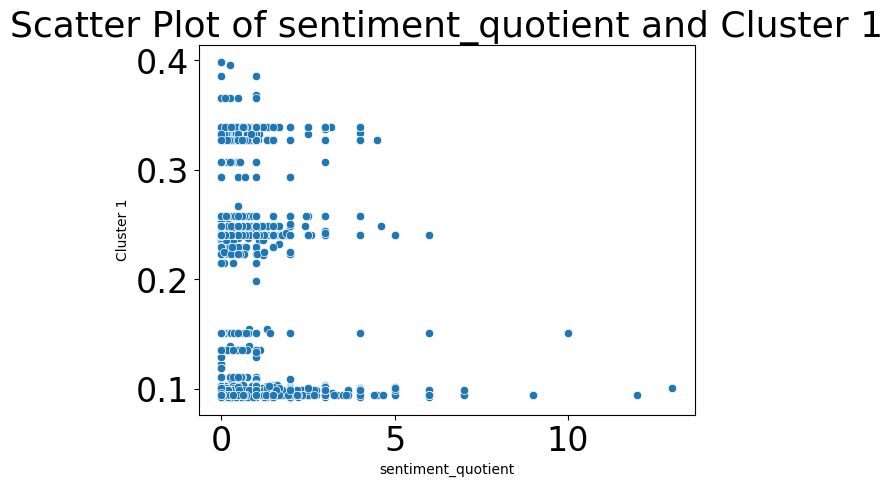

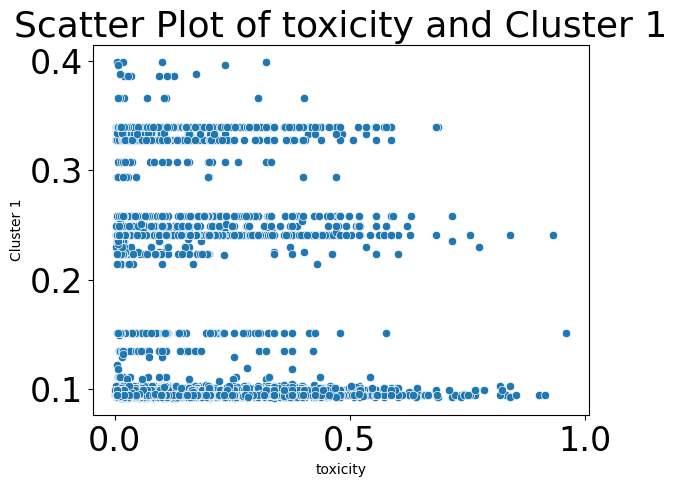

In [24]:
# testing linear relatio between features and clusters
for x in features.columns[:-1]:
    sns.scatterplot(x=full_data[x], y=full_data['Cluster 1'])
    plt.title(f'Scatter Plot of {x} and Cluster 1')
    plt.xlabel(f'{x}')
    plt.ylabel('Cluster 1')
    plt.show()

In [25]:
corr_1 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 2', 'Cluster 3', 'Cluster 4']).corr(method='spearman')
corr_1['Cluster 1'].sort_values(ascending=False)

Cluster 1                  1.000000
sentiment_quotient         0.021832
positive_sentiment         0.021711
flesch_reading_ease        0.015353
total_message_count        0.011263
exclamation_count          0.010583
own_message_count          0.010350
channel_messages           0.010190
forwarded_message_count    0.009772
liwc_We                    0.009394
forwarded_message          0.007033
liwc_You                   0.006429
verb_count                 0.005170
action_quotient            0.005048
question_count             0.005043
was_forwarded              0.004902
adj_count                  0.003666
sent_count                 0.003639
noun_count                 0.003590
toxicity                   0.003502
negative_sentiment         0.001333
liwc_Other                 0.001036
liwc_I                     0.000791
liwc_Affect                0.000031
own_message               -0.000415
avg_word_length           -0.001923
avg_sent_length           -0.001964
word_count                -0

In [26]:
# highly correlated features with Cluster 1
corr_1['Cluster 1'][abs(corr_1['Cluster 1']) > 0.7]

Cluster 1    1.0
Name: Cluster 1, dtype: float64

## Cluster 2

In [27]:
corr_2 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 1', 'Cluster 3', 'Cluster 4']).corr(method='spearman')
corr_2['Cluster 2'].sort_values(ascending=False)

Cluster 2                  1.000000
group_messages             0.009998
neutral_sentiment          0.009734
emoji_count                0.004412
word_count                 0.003429
avg_sent_length            0.003059
avg_word_length            0.002044
own_message                0.000373
liwc_Affect                0.000241
liwc_Other                 0.000176
negative_sentiment        -0.000707
toxicity                  -0.000845
liwc_I                    -0.001413
noun_count                -0.001459
sent_count                -0.001479
adj_count                 -0.002253
verb_count                -0.003508
question_count            -0.003763
liwc_You                  -0.004068
was_forwarded             -0.005307
forwarded_message         -0.005468
liwc_We                   -0.006470
action_quotient           -0.007598
forwarded_message_count   -0.008293
exclamation_count         -0.008303
own_message_count         -0.009291
total_message_count       -0.009933
channel_messages          -0

In [28]:
# highly correlated features with Cluster 2
corr_2['Cluster 2'][abs(corr_2['Cluster 2']) > 0.7]

Cluster 2    1.0
Name: Cluster 2, dtype: float64

## Cluster 3

In [29]:
corr_3 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 1', 'Cluster 2', 'Cluster 4']).corr(method='spearman')
corr_3['Cluster 3'].sort_values(ascending=False)

Cluster 3                  1.000000
liwc_You                   0.013669
channel_messages           0.011664
adj_count                  0.011056
action_quotient            0.009606
toxicity                   0.009552
exclamation_count          0.007181
negative_sentiment         0.006756
forwarded_message_count    0.006619
total_message_count        0.005590
forwarded_message          0.005195
liwc_Other                 0.005103
verb_count                 0.004369
neutral_sentiment          0.004308
noun_count                 0.004192
liwc_Affect                0.002905
liwc_We                    0.002625
was_forwarded              0.000609
sent_count                 0.000494
liwc_I                    -0.000283
question_count            -0.000418
own_message_count         -0.001606
word_count                -0.002766
avg_word_length           -0.004636
sentiment_quotient        -0.005703
avg_sent_length           -0.006064
flesch_reading_ease       -0.008148
emoji_count               -0

In [30]:
# highly correlated features with Cluster 3
corr_3['Cluster 3'][abs(corr_3['Cluster 3']) > 0.7]

Cluster 3    1.0
Name: Cluster 3, dtype: float64

# Cluster 4

In [31]:
corr_4 = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster', 'Cluster 1', 'Cluster 2', 'Cluster 3']).corr(method='spearman')
corr_4['Cluster 4'].sort_values(ascending=False)

Cluster 4                  1.000000
sentiment_quotient         0.021378
positive_sentiment         0.019662
flesch_reading_ease        0.012050
exclamation_count          0.011914
total_message_count        0.011843
forwarded_message_count    0.011713
channel_messages           0.010540
own_message_count          0.009733
forwarded_message          0.009010
liwc_We                    0.008594
action_quotient            0.007092
was_forwarded              0.006222
adj_count                  0.006096
liwc_You                   0.006079
verb_count                 0.005959
question_count             0.004253
noun_count                 0.004162
toxicity                   0.004115
sent_count                 0.003507
negative_sentiment         0.001864
liwc_Other                 0.001592
liwc_I                     0.001306
liwc_Affect               -0.001879
avg_word_length           -0.002287
word_count                -0.002648
emoji_count               -0.003288
own_message               -0

In [32]:
# highly correlated features with Cluster 4
corr_4['Cluster 4'][abs(corr_4['Cluster 4']) > 0.7]

Cluster 4    1.0
Name: Cluster 4, dtype: float64

    No correlations for any of the features

# Multinomial Logistic Regression

In [33]:
features.columns

Index(['noun_count', 'verb_count', 'adj_count', 'positive_sentiment',
       'negative_sentiment', 'neutral_sentiment', 'channel_messages',
       'group_messages', 'sent_count', 'word_count', 'avg_sent_length',
       'avg_word_length', 'exclamation_count', 'question_count', 'emoji_count',
       'flesch_reading_ease', 'liwc_I', 'liwc_We', 'liwc_You', 'liwc_Other',
       'liwc_Affect', 'own_message', 'forwarded_message',
       'total_message_count', 'was_forwarded', 'own_message_count',
       'forwarded_message_count', 'action_quotient', 'sentiment_quotient',
       'toxicity', 'cluster'],
      dtype='object')

In [34]:
# create train test split
X = features.drop(columns=['cluster'])
y = features['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [35]:
# impute missing values & scale data
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = imputer.fit_transform(X_test)
X_test = scaler.fit_transform(X_test)

In [36]:
# combine over and under sampling to handle class imbalance
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [37]:
model = LogisticRegression(solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [38]:
# predictions
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)

In [39]:
# evaluate model
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 Score:', model.score(X_test, y_test))
print('\nClassification Report:\n', classification_report(y_test, predictions))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, predictions))

Accuracy: 0.2773391235688906
F1 Score: 0.2773391235688906

Classification Report:
               precision    recall  f1-score   support

   Cluster 1       0.10      0.12      0.11       494
   Cluster 2       0.80      0.29      0.42      3963
   Cluster 3       0.00      0.27      0.00        11
   Cluster 4       0.13      0.35      0.19       598

    accuracy                           0.28      5066
   macro avg       0.26      0.26      0.18      5066
weighted avg       0.65      0.28      0.36      5066


Confusion Matrix:
 [[  61  136  145  152]
 [ 448 1133 1195 1187]
 [   3    3    3    2]
 [  74  153  163  208]]


    MLR cannot handle class imbalance well

# Network Metrics

In [40]:
adj = np.load('../results/author_full_adj.npy')

In [41]:
G = nx.from_numpy_array(adj)

In [42]:
# get basic information about graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = int(np.mean(list(dict(G.degree()).values())))
min_degree = np.min(list(dict(G.degree()).values()))
max_degree = np.max(list(dict(G.degree()).values()))

In [43]:
print('Total Number of Nodes:', num_nodes)
print('Total Number of Edges:', num_edges)
print('Average Degree:', avg_degree)
print('Minimum Degree:', min_degree)
print('Maximum Degree:', max_degree)

Total Number of Nodes: 16885
Total Number of Edges: 60965422
Average Degree: 7221
Minimum Degree: 0
Maximum Degree: 16821
